In [1]:
import datasets
import collections
import random

/home/liuyewei/miniconda3/envs/metalora/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import (
    AutoTokenizer,
)

tokenizer = AutoTokenizer.from_pretrained("../models/Qwen3-8B/", padding_side="left", use_fast=True)
tokenizer.chat_template = "{%- if tools %}\n    {{- '<|im_start|>system\\n' }}\n    {%- if messages[0].role == 'system' %}\n        {{- messages[0].content + '\\n\\n' }}\n    {%- endif %}\n    {{- \"# Tools\\n\\nYou may call one or more functions to assist with the user query.\\n\\nYou are provided with function signatures within <tools></tools> XML tags:\\n<tools>\" }}\n    {%- for tool in tools %}\n        {{- \"\\n\" }}\n        {{- tool | tojson }}\n    {%- endfor %}\n    {{- \"\\n</tools>\\n\\nFor each function call, return a json object with function name and arguments within <tool_call></tool_call> XML tags:\\n<tool_call>\\n{\\\"name\\\": <function-name>, \\\"arguments\\\": <args-json-object>}\\n</tool_call><|im_end|>\\n\" }}\n{%- else %}\n    {%- if messages[0].role == 'system' %}\n        {{- '<|im_start|>system\\n' + messages[0].content + '<|im_end|>\\n' }}\n    {%- endif %}\n{%- endif %}\n{%- set ns = namespace(multi_step_tool=true, last_query_index=messages|length - 1) %}\n{%- for message in messages[::-1] %}\n    {%- set index = (messages|length - 1) - loop.index0 %}\n    {%- if ns.multi_step_tool and message.role == \"user\" and message.content is string and not(message.content.startswith('<tool_response>') and message.content.endswith('</tool_response>')) %}\n        {%- set ns.multi_step_tool = false %}\n        {%- set ns.last_query_index = index %}\n    {%- endif %}\n{%- endfor %}\n{%- for message in messages %}\n    {%- if message.content is string %}\n        {%- set content = message.content %}\n    {%- else %}\n        {%- set content = '' %}\n    {%- endif %}\n    {%- if (message.role == \"user\") or (message.role == \"system\" and not loop.first) %}\n        {{- '<|im_start|>' + message.role + '\\n' + content + '<|im_end|>\\n' }}\n    {%- elif message.role == \"assistant\" %}\n        {%- set reasoning_content = '' %}\n        {%- if message.reasoning_content is string %}\n            {%- set reasoning_content = message.reasoning_content %}\n        {%- else %}\n            {%- if '</think>' in content %}\n                {%- set reasoning_content = content.split('</think>')[0].rstrip('\\n').split('<think>')[-1].lstrip('\\n') %}\n                {%- set content = content.split('</think>')[-1].lstrip('\\n') %}\n            {%- endif %}\n        {%- endif %}\n        {%- if loop.index0 > ns.last_query_index %}\n            {%- if (loop.last or (not loop.last and reasoning_content)) and (enable_thinking is not defined or enable_thinking != false) %}\n                {{- '<|im_start|>' + message.role + '\\n<think>\\n' + reasoning_content.strip('\\n') + '\\n</think>\\n\\n' + content.lstrip('\\n') }}\n            {%- else %}\n                {{- '<|im_start|>' + message.role + '\\n' + content }}\n            {%- endif %}\n        {%- else %}\n            {{- '<|im_start|>' + message.role + '\\n' + content }}\n        {%- endif %}\n        {%- if message.tool_calls %}\n            {%- for tool_call in message.tool_calls %}\n                {%- if (loop.first and content) or (not loop.first) %}\n                    {{- '\\n' }}\n                {%- endif %}\n                {%- if tool_call.function %}\n                    {%- set tool_call = tool_call.function %}\n                {%- endif %}\n                {{- '<tool_call>\\n{\"name\": \"' }}\n                {{- tool_call.name }}\n                {{- '\", \"arguments\": ' }}\n                {%- if tool_call.arguments is string %}\n                    {{- tool_call.arguments }}\n                {%- else %}\n                    {{- tool_call.arguments | tojson }}\n                {%- endif %}\n                {{- '}\\n</tool_call>' }}\n            {%- endfor %}\n        {%- endif %}\n        {{- '<|im_end|>\\n' }}\n    {%- elif message.role == \"tool\" %}\n        {%- if loop.first or (messages[loop.index0 - 1].role != \"tool\") %}\n            {{- '<|im_start|>user' }}\n        {%- endif %}\n        {{- '\\n<tool_response>\\n' }}\n        {{- content }}\n        {{- '\\n</tool_response>' }}\n        {%- if loop.last or (messages[loop.index0 + 1].role != \"tool\") %}\n            {{- '<|im_end|>\\n' }}\n        {%- endif %}\n    {%- endif %}\n{%- endfor %}\n{%- if add_generation_prompt %}\n    {{- '<|im_start|>assistant\\n' }}\n    {%- if enable_thinking is not defined or enable_thinking != false %}\n        {{- '<think>\\n\\n</think>\\n\\n' }}\n    {%- endif %}\n{%- endif %}"

In [3]:
def conversations_from_qapairs(item_list):
    for item in item_list:
        conversations = []
        for qa in item['qa_pairs']:
            question = qa['question']
            answer = qa['answer']
            conversations.append({"role": "user", "content": question})
            conversations.append({"role": "assistant", "content": answer})
        item['conversations'] = conversations
    return item_list

def save(data, save_path):
    import json, os
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    with open(save_path, 'w') as f:
        for item in data:
            id = item['id']
            context = item['context']
            conversations = item['conversations']
            f.write(json.dumps({"id": id, "context": context, "conversations": conversations}) + "\n")

In [4]:
q = "who is adam"
a = "I don't know"
tokensq = tokenizer.tokenize(q)
tokensa = tokenizer.tokenize(a)
message = [{"role": "user", "content": q}, {"role": "assistant", "content": a}]
tokensm = tokenizer.apply_chat_template(
    message,
    add_generation_prompt=False,   # adds the final assistant tag
    tokenize=True,               # returns text instead of IDs
    enable_thinking=False         # adds <think></think> block for the final assistant tag
)
chat_len = len(tokensm) - len(tokensq) - len(tokensa)
print(f"Chat overhead tokens: {chat_len}")

Chat overhead tokens: 10


In [5]:
from datasets import Dataset as HFDataset
import numpy as np

MAP_BATCH_SIZE = 2048
MAP_NUM_PROC = 16

def compute_context_and_conversations_tokens_num(data):
        if isinstance(data, list):
            hf_dataset = HFDataset.from_list(data)
        elif isinstance(data, HFDataset):
            hf_dataset = data
        else:
            raise TypeError("data must be a HuggingFace Dataset or a list of dicts")

        def compute_len(batch):
            context_enc = tokenizer(
                batch["context"],
                add_special_tokens=False,
                truncation=False,
                return_attention_mask=False,
                return_token_type_ids=False,
            )
            conversation_enc = tokenizer.apply_chat_template(
                batch["conversations"],
                add_generation_prompt=False,
                tokenize=True,
                enable_thinking=False,
            )
            return {"context_len": [len(ids) for ids in context_enc["input_ids"]], "conversations_len": [len(ids) for ids in conversation_enc]}

        hf_dataset = hf_dataset.map(
            compute_len,
            batched=True,
            batch_size=MAP_BATCH_SIZE,
            num_proc=MAP_NUM_PROC,
            desc="Computing token lengths",
            # writer_batch_size
        )

        return np.array(hf_dataset["context_len"], dtype=np.int32), np.array(hf_dataset["conversations_len"], dtype=np.int32)

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_len_hist(
    lengths,
    bins=50,
    xlim=None,
    ylim=None,
    bin_range=None,
    density=False,
    logy=False,
    title="Length histogram",
    xlabel="Length",
    ylabel=None,
):
    lengths = np.asarray(lengths)
    lengths = lengths[np.isfinite(lengths)]

    # --- Compute statistics ---
    mean_val = np.mean(lengths)
    median_val = np.median(lengths)
    min_val = np.min(lengths)
    max_val = np.max(lengths)

    fig, ax = plt.subplots(figsize=(9, 5))

    hist_kwargs = dict(bins=bins, density=density)
    if bin_range is not None and isinstance(bins, (int, np.integer)):
        hist_kwargs["range"] = bin_range

    ax.hist(lengths, **hist_kwargs, alpha=0.7, edgecolor="black")

    # --- Plot statistical markers ---
    ax.axvline(mean_val, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_val:.2f}")
    ax.axvline(median_val, color="green", linestyle="-.", linewidth=2, label=f"Median = {median_val:.2f}")
    ax.axvline(min_val, color="blue", linestyle=":", linewidth=2, label=f"Min = {min_val:.2f}")
    ax.axvline(max_val, color="purple", linestyle=":", linewidth=2, label=f"Max = {max_val:.2f}")

    # --- Annotation box ---
    stats_text = (
        f"Mean: {mean_val:.2f}\n"
        f"Median: {median_val:.2f}\n"
        f"Min: {min_val:.2f}\n"
        f"Max: {max_val:.2f}"
    )
    ax.text(
        0.98, 0.98, stats_text,
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
    )

    # --- Labels and formatting ---
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel or ("Density" if density else "Count"))

    if xlim is not None:
        ax.set_xlim(*xlim)
    if ylim is not None:
        ax.set_ylim(*ylim)
    if logy:
        ax.set_yscale("log")

    ax.grid(True, alpha=0.25)
    ax.legend()
    plt.tight_layout()
    plt.show()
    print(f"Total samples: {len(lengths)}")

In [7]:
def display_conversations(item_list, firstk=20):
    for i in range(firstk):
        print(item_list[i]['context'])
        for d in item_list[i]['conversations']:
            print(f"{d['role']}: {d['content']}")
        print("===================================================")

In [8]:
from copy import deepcopy

def duplicate_context(item_list, num=2, ctxs=None):
    l = len(item_list)
    ls = [i for i in range(l)]
    new_item_list = deepcopy(item_list)
    for i, item in enumerate(new_item_list):   
        if ctxs is None: 
            indices = [i]
            while len(indices) < num:
                j = random.randint(0, l - 1)
                if j not in indices:
                    indices.append(j)
            new_item_list[i]['context'] = "\n\n".join(random.sample([item_list[j]['context'] for j in indices], k=num))
        else:
            assert item['context'] in ctxs
            indices = [ctxs.index(item['context'])]
            while len(indices) < num:
                j = random.randint(0, len(ctxs) - 1)
                if j not in indices:
                    indices.append(j)
            new_item_list[i]['context'] = "\n\n".join(random.sample([ctxs[j] for j in indices], k=num))
    return new_item_list

In [9]:
context_lens_dict = {}
conv_lens_dict = {}
item_list_dict = {}
ift_c1qa_datasets = []

# msmacrov1.1

In [10]:
from datasets import concatenate_datasets
from copy import deepcopy

# ms marco ('microsoft/ms_marco')
data = datasets.load_dataset('microsoft/ms_marco', 'v1.1')
data = concatenate_datasets([
    data["train"],
    data["validation"],
])
data = list(data)
random.seed(0)

item_list = []
for item in data:
    passages = item['passages']
    if sum(passages['is_selected']) == 0 or len(item['answers']) == 0:
        continue
    context = "\n\n".join([passages['passage_text'][i] for i in range(len(passages['passage_text']))])
    question = item['query']
    answer = item['answers'][0]
    item_list.append({
        'context': context,
        'conversations': [
            {"role": "user", "content": question.strip()},
            {"role": "assistant", "content": answer.strip()},
        ]
    })
item_list = duplicate_context(item_list, num=2)
context_lens_dict['msmarcov1.1'], conv_lens_dict['msmarcov1.1'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['msmarcov1.1'] = item_list

Computing token lengths (num_proc=16): 100%|██████████| 89321/89321 [02:27<00:00, 606.81 examples/s] 


In [11]:
display_conversations(item_list_dict['msmarcov1.1'])
ift_c1qa_datasets.append('msmarcov1.1')

The key kinds of symmetry relevant in the study of organismal biology are radial and bilateral symmetry. In studying the evolutionary development of symmetry in plants and animals, one fascinating element that emerges is that symmetry is not easily broken in natural selection.

For example, many jellyfish have four oral arms that extend below their body and their body structure can therefore be divided into four equal parts. This type of radial symmetry is referred to as tetramerism. Additionally, two groups of cnidarians, corals and sea anemones, exhibit six-or eight-fold symmetry. These types of symmetry are referred to as hexamerism and octamerism, respectively. It should be noted that cnidarians are not the only animals to exhibit radial symmetry. The echinoderms also display

radial symmetry. n. 1. (Biology) a type of structure of an organism or part of an organism in which a vertical cut through the axis in any of two or more planes produces two halves that are mirror images of e

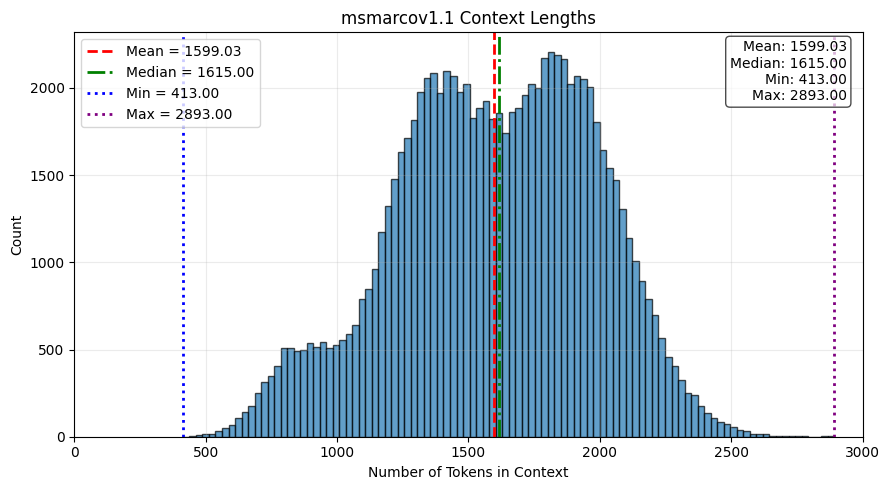

Total samples: 89321


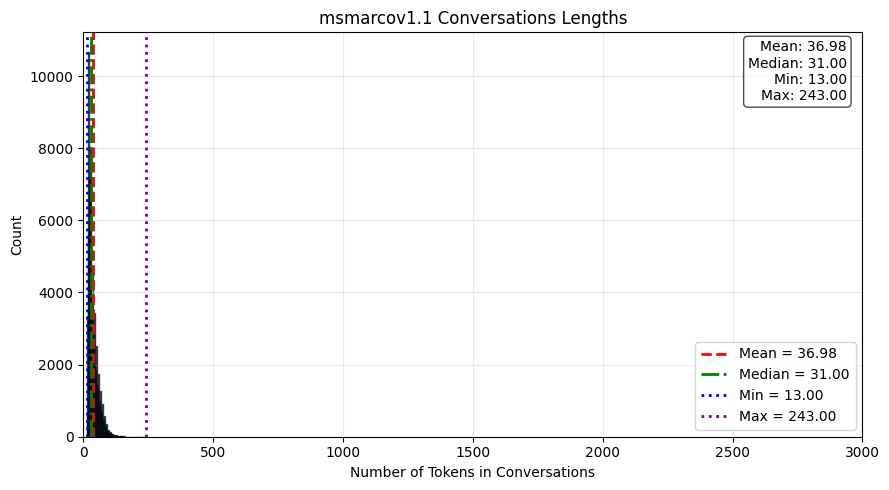

Total samples: 89321


In [12]:
plot_len_hist(
    context_lens_dict['msmarcov1.1'],
    bins=100,
    xlim=(0, 3000),
    title="msmarcov1.1 Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['msmarcov1.1'],
    bins=100,
    xlim=(0, 3000),
    title="msmarcov1.1 Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# msmacro v2.1

In [13]:
# ms marco ('microsoft/ms_marco')
output_list = []
data = datasets.load_dataset('microsoft/ms_marco', 'v2.1')
data = concatenate_datasets([
    data["train"],
    data["validation"],
])
data = list(data)
random.seed(0)

item_list = []
for item in data:
    passages = item['passages']
    if sum(passages['is_selected']) == 0 or len(item['answers']) == 0:
        continue
    context = "\n\n".join([passages['passage_text'][i] for i in range(len(passages['passage_text']))])
    question = item['query']
    answer = item['answers'][0]
    item_list.append({
        'context': context,
        'conversations': [
            {"role": "user", "content": question.strip()},
            {"role": "assistant", "content": answer.strip()},
        ]
    })
item_list = duplicate_context(item_list, num=2)
context_lens_dict['msmarcov2.1'], conv_lens_dict['msmarcov2.1'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['msmarcov2.1'] = item_list

Computing token lengths (num_proc=16): 100%|██████████| 558517/558517 [09:06<00:00, 1021.36 examples/s]


In [14]:
display_conversations(item_list_dict['msmarcov2.1'])
ift_c1qa_datasets.append('msmarcov2.1')

Directions. 1  Step 1 - Selecting the beets. 2  How many beets and where to get them. 3  Step 2 - Trim the ends and cut into smaller pieces.  Step 3 -Wash the 1  beets! Step 4 - Cook the beets.  Step 5 - Cool the 1  beets. Step 6 - Trim, peel and 2  slice. Step 7 - Package, label and  freeze.

The beets need to be prepared being storing. Greens should be removed; leaving about 2 inches of stem to avoid any bleeding of the root. Greens can be easily frozen for later use in dishes (link to how to buy, store and freeze beet greens). As you harvest from your garden, layer beets within your storage unit. Making sure the soil, sawdust or peat moss is continually damp. Beets will last for 2 to 3 months using this method.

To freeze beets, wash and remove stems leaving about 2 inches of the stem to prevent any bleeding. Next, boil the beets until they are of the consistency that you prefer. This can typically take about 20 to 45 minutes depending on the size of the beets and variation. Smaller

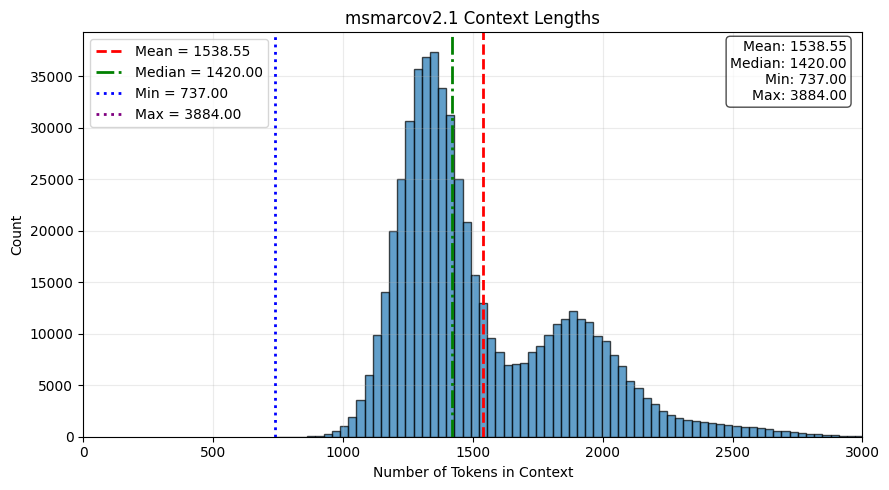

Total samples: 558517


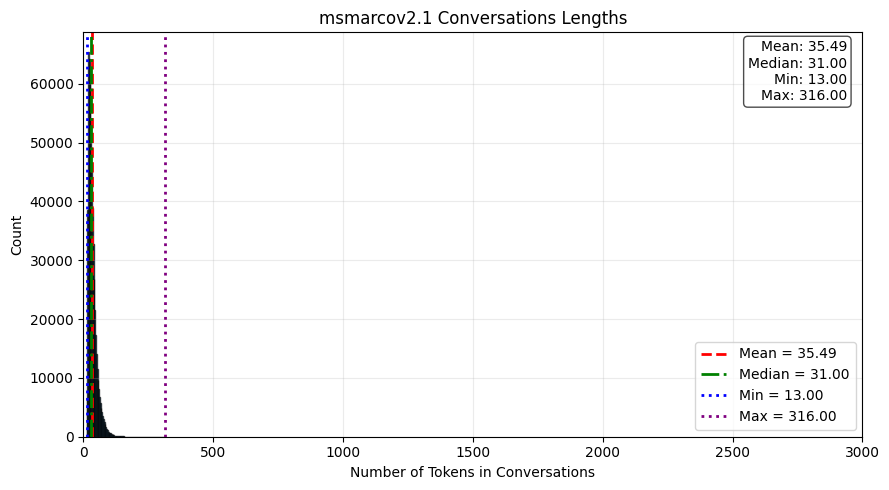

Total samples: 558517


In [15]:
plot_len_hist(
    context_lens_dict['msmarcov2.1'],
    bins=100,
    xlim=(0, 3000),
    title="msmarcov2.1 Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['msmarcov2.1'],
    bins=100,
    xlim=(0, 3000),
    title="msmarcov2.1 Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# Squad

In [16]:
from datasets import load_dataset
import os
from collections import defaultdict
import random

data = load_dataset(os.path.join("..", "data", "squad"), split="train")
text_to_idx = defaultdict(list)
for i, ex in enumerate(data):
    ctx = str(ex["context"]).strip()
    text_to_idx[ctx].append(i)
item_list = []
ctxs = list(text_to_idx.keys())
ctx_list = list(text_to_idx.keys())
for item in data:
    ctx = str(item["context"]).strip()
    assert ctx in ctx_list
    question = str(item["question"]).strip()
    answer = str(item["answers"]["text"][0]).strip()
    item_list.append({
        'context': ctx,
        'conversations': [
            {"role": "user", "content": question},
            {"role": "assistant", "content": answer},
        ]
    })
item_list = duplicate_context(item_list, num=10, ctxs=ctxs)
context_lens_dict['squad'], conv_lens_dict['squad'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['squad'] = item_list 

Computing token lengths (num_proc=16): 100%|██████████| 87599/87599 [03:12<00:00, 454.99 examples/s] 


In [17]:
display_conversations(item_list_dict['squad'])
ift_c1qa_datasets.append('squad')

Temperatures below 0 °C (32 °F) or above 25 °C (77 °F) are rare. Cork Airport records an average of 1,227.9 millimetres (4.029 ft) of precipitation annually, most of which is rain. The airport records an average of 7 days of hail and 11 days of snow or sleet a year; though it only records lying snow for 2 days of the year. The low altitude of the city, and moderating influences of the harbour, mean that lying snow very rarely occurs in the city itself. There are on average 204 "rainy" days a year (over 0.2 millimetres (0.0079 in) of rainfall), of which there are 73 days with "heavy rain" (over 5 millimetres (0.20 in)). Cork is also a generally foggy city, with an average of 97 days of fog a year, most common during mornings and during winter. Despite this, however, Cork is also one of Ireland's sunniest cities, with an average of 3.9 hours of sunshine every day and only having 67 days where there is no "recordable sunshine", mostly during and around winter.

At this time, Hal B. Wallis

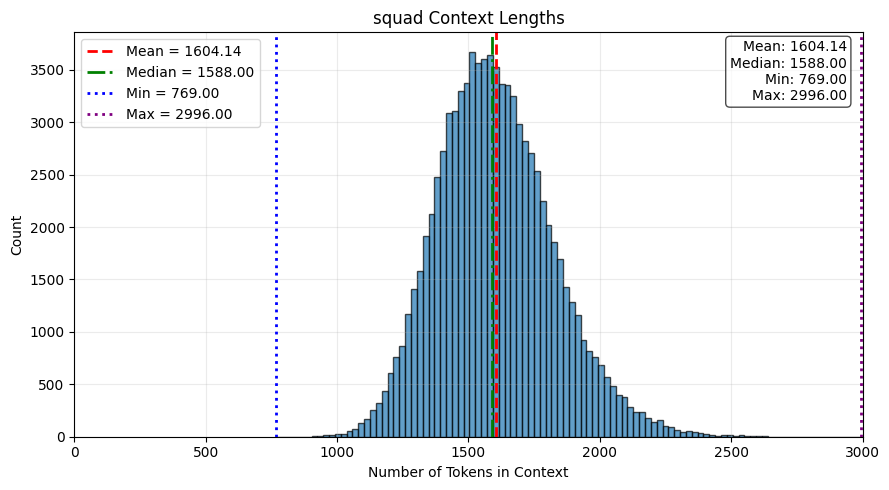

Total samples: 87599


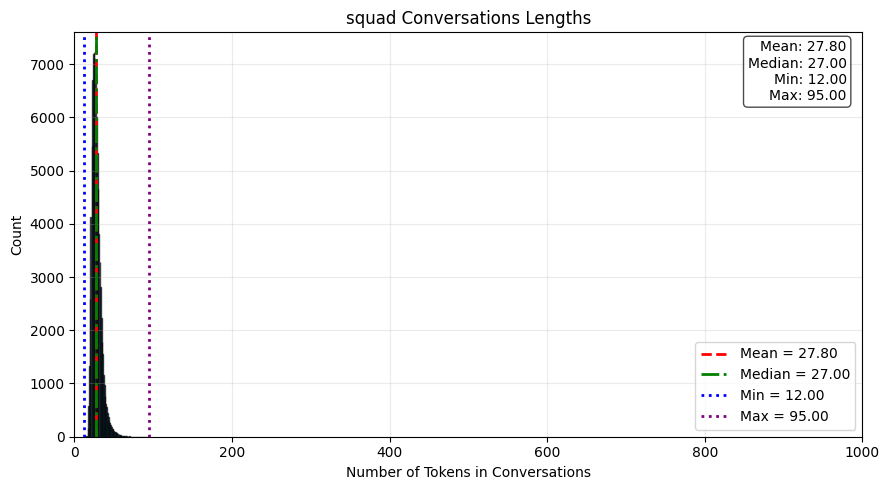

Total samples: 87599


In [18]:
plot_len_hist(
    context_lens_dict['squad'],
    bins=100,
    xlim=(0, 3000),
    title="squad Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['squad'],
    bins=100,
    xlim=(0, 1000),
    title="squad Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# race

In [19]:
from datasets import load_dataset
import os
from collections import defaultdict
import random

data = load_dataset("ehovy/race", "all")
data = concatenate_datasets([
    data["train"],
    data["validation"],
])
data = list(data)
item_list = []
answer_dict = {'A':0, 'B':1, 'C':2, 'D':3}
text_to_idx = defaultdict(list)
for i, ex in enumerate(data):
    ctx = str(ex["article"]).strip()
    text_to_idx[ctx].append(i)
ctxs = list(text_to_idx.keys())
for item in data:
    context = item['article']
    question = str(item['question']).strip()
    answer = str(item['options'][answer_dict[item['answer']]]).strip()
    item_list.append({
        'context': context,
        'conversations': [
            {"role": "user", "content": question},
            {"role": "assistant", "content": answer},
        ]
    })
item_list = duplicate_context(item_list, num=4, ctxs=ctxs)
context_lens_dict['race'], conv_lens_dict['race'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['race'] = item_list 

Computing token lengths (num_proc=16): 100%|██████████| 92753/92753 [02:39<00:00, 580.94 examples/s] 


In [20]:
display_conversations(item_list_dict['race'])
ift_c1qa_datasets.append('race')

Last week I talked with some of my students about what they wanted to do after they graduated, and what kind of job prospects  they thought they had.
Given that I teach students who are training to be doctors, I was surprised do find that most thought that they would not be able to get the jobs they wanted without "outside help". "What kind of help is that?" I asked, expecting them to tell me that they would need a   or family friend to help them out.
"Surgery ," one replied.
I was pretty alarmed by that response. It seems that the graduates of today are increasingly willing to go under the knife to get ahead of others when it comes to getting a job .
One girl told me that she was considering surgery to increase her height. "They break your legs, put in special extending screws, and slowly expand the gap between the two ends of the bone as it re-grows, you can get at least 5 cm taller!"
At that point, I was shocked. I am short, I can't deny that, but I don't think I would put myself th

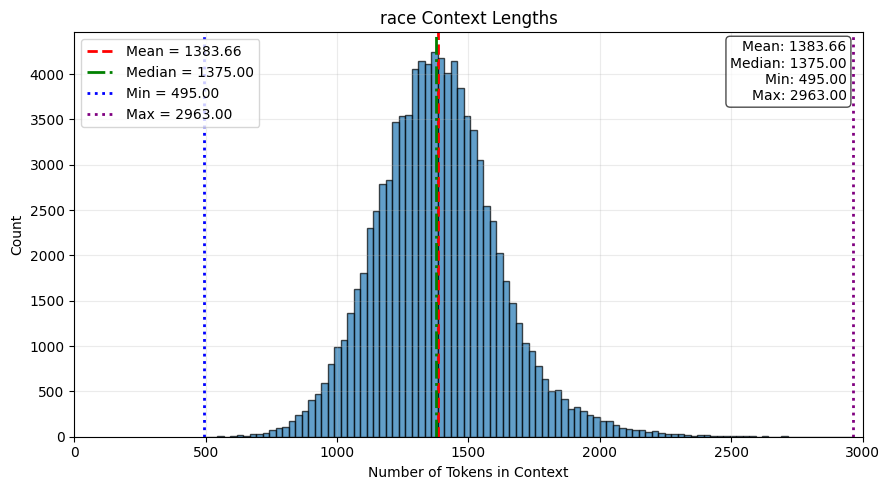

Total samples: 92753


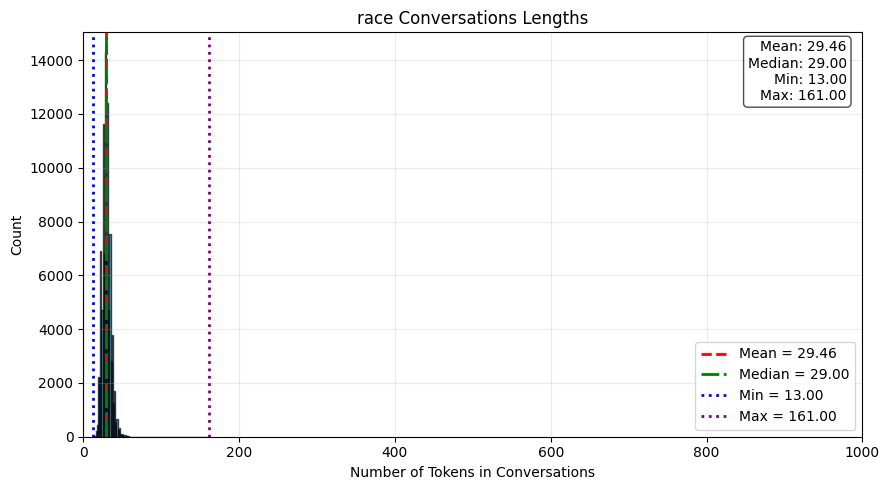

Total samples: 92753


In [21]:
plot_len_hist(
    context_lens_dict['race'],
    bins=100,
    xlim=(0, 3000),
    title="race Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['race'],
    bins=100,
    xlim=(0, 1000),
    title="race Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# duorc(selfrc, easy)

In [22]:
from datasets import load_dataset
import os
from collections import defaultdict
import random

data = load_dataset("ibm-research/duorc", "SelfRC")
data = concatenate_datasets([
    data["train"],
    data["validation"],
])
data = list(data)

item_list = []
for item in data:
    if len(item['answers']) == 0:
        continue
    context = item['plot'].strip()
    question = str(item['question']).strip()
    answer = str(item['answers'][0]).strip()
    item_list.append({
        'context': context,
        'conversations': [
            {"role": "user", "content": question},
            {"role": "assistant", "content": answer},
        ]
    })
item_list = duplicate_context(item_list, num=2)
context_lens_dict['duorc/selfrc'], conv_lens_dict['duorc/selfrc'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['duorc/selfrc'] = item_list 

Computing token lengths (num_proc=16): 100%|██████████| 72939/72939 [02:34<00:00, 472.37 examples/s] 


In [23]:
display_conversations(item_list_dict['duorc/selfrc'])
ift_c1qa_datasets.append('duorc/selfrc')

200 years in the future, Mars has been colonized by a high-tech company.
Melanie Ballard (Natasha Henstridge) arrives by train to a Mars mining camp which has cut all communication links with the company headquarters. She's not alone, as she is with a group of fellow police officers. They find the mining camp deserted except for a person in the prison, Desolation Williams (Ice Cube), who seems to laugh about them because they are all going to die. They were supposed to take Desolation to headquarters, but decide to explore first to find out what happened.They find a man inside an encapsulated mining car, who tells them not to open it. However, they do and he tries to kill them. One of the cops witnesses strange men with deep scarred and heavily tattooed faces killing the remaining survivors. The cops realise they need to leave the place fast.Desolation explains that the miners opened a kind of Martian construction in the soil which unleashed red dust. Those who breathed that dust becam

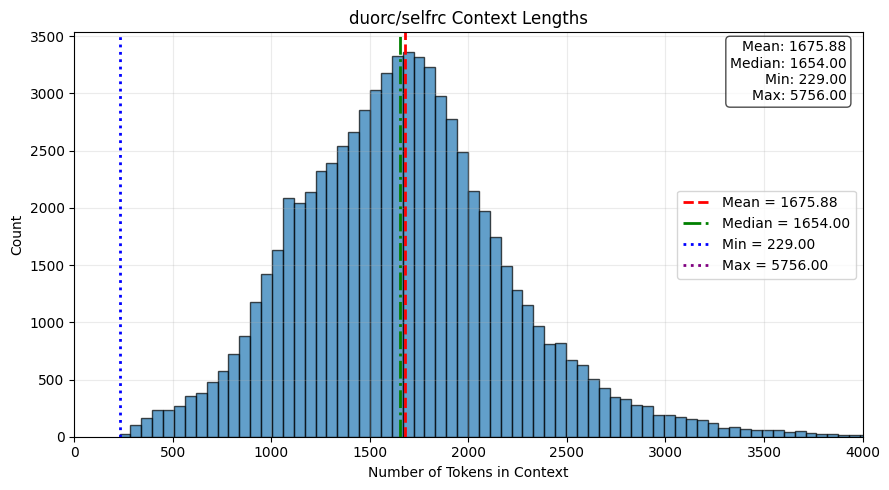

Total samples: 72939


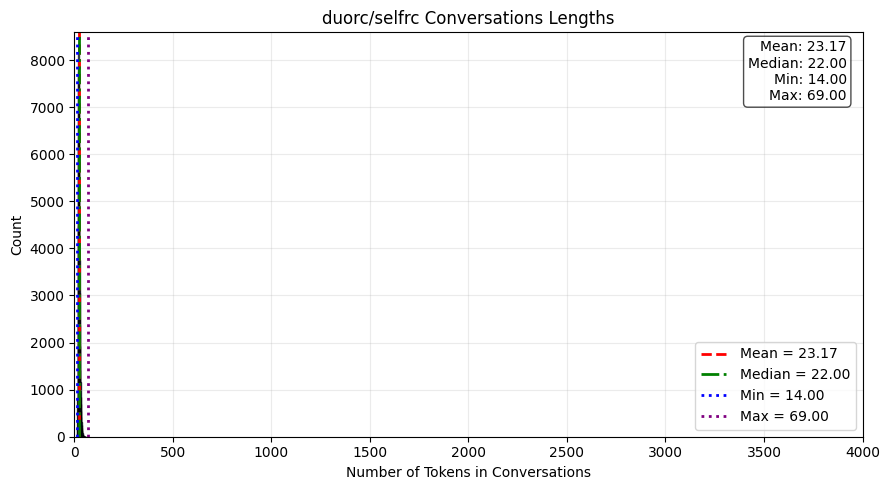

Total samples: 72939


In [24]:
plot_len_hist(
    context_lens_dict['duorc/selfrc'],
    bins=100,
    xlim=(0, 4000),
    title="duorc/selfrc Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['duorc/selfrc'],
    bins=100,
    xlim=(0, 4000),
    title="duorc/selfrc Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# duorc(paraphraserc hard)

In [25]:
from datasets import load_dataset
import os
from collections import defaultdict
import random

data = load_dataset("ibm-research/duorc", "ParaphraseRC")
data = concatenate_datasets([
    data["train"],
    data["validation"],
])
data = list(data)

item_list = []
for item in data:
    if len(item['answers']) == 0:
        continue
    context = item['plot'].strip()
    question = str(item['question']).strip()
    answer = str(item['answers'][0]).strip()
    item_list.append({
        'context': context,
        'conversations': [
            {"role": "user", "content": question},
            {"role": "assistant", "content": answer},
        ]
    })
    
context_lens_dict['duorc/paraphraserc'], conv_lens_dict['duorc/paraphraserc'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['duorc/paraphraserc'] = item_list 

Computing token lengths (num_proc=16): 100%|██████████| 71863/71863 [02:39<00:00, 451.66 examples/s] 


In [26]:
display_conversations(item_list_dict['duorc/paraphraserc'])
ift_c1qa_datasets.append('duorc/paraphraserc')   

Set in the second half of the 22nd century, Mars has been 84% terraformed, allowing humans to walk on the surface without pressure suits. Martian society has become matriarchal, with women in most positions of authority. The story concerns police officer Melanie Ballard (Natasha Henstridge), second in command of a team alongside Sergeant Jericho (Jason Statham) sent to a remote mining outpost to transport prisoner Desolation Williams (Ice Cube). Arriving at the remote mining town, Ballard finds all of the people missing. She learns that they had discovered an underground doorway created by an ancient Martian civilization. When the door was opened it released disembodied spirits or "ghosts", which took possession of the miners.
The possessed miners commit horrific acts of death and destruction, along with self-mutilation. When team leader Helena Bradock (Pam Grier) is murdered, Ballard must assume command, fight off the possessed miners, escape the town and hopefully destroy the ghosts.

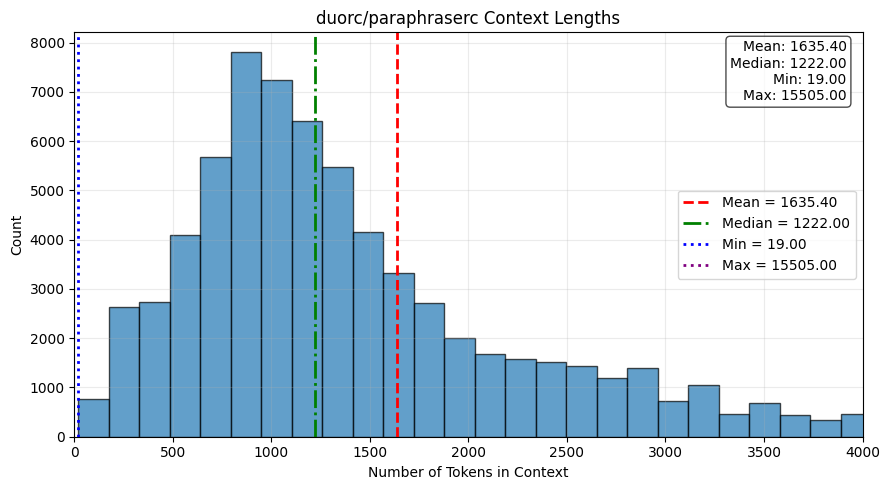

Total samples: 71863


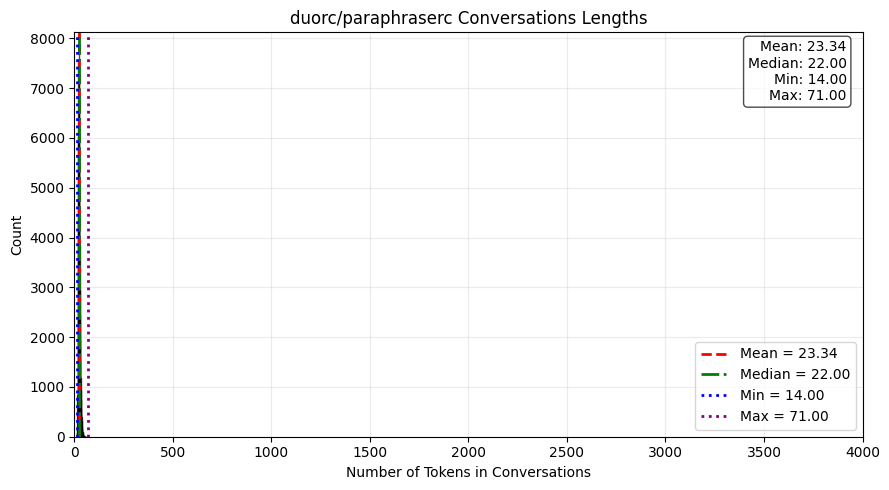

Total samples: 71863


In [27]:
plot_len_hist(
    context_lens_dict['duorc/paraphraserc'],
    bins=100,
    xlim=(0, 4000),
    title="duorc/paraphraserc Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['duorc/paraphraserc'],
    bins=100,
    xlim=(0, 4000),
    title="duorc/paraphraserc Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# Hotpotqa (distractor)

In [28]:
data = load_dataset("hotpotqa/hotpot_qa", "distractor")
data = concatenate_datasets([
    data["train"],
])
data = list(data)

random.seed(0)

item_list = []
for item in data:
    contest_list = []
    for sentences in item['context']['sentences']:
        contest_list.append("".join(sentences))
    context = "\n\n".join(contest_list)
    item_list.append({
        'context': context,
        'conversations': [{"role": "user", "content": item['question'].strip()}, {"role": "assistant", "content": item['answer'].strip()}]
    })

context_lens_dict['hotpotqa(distractor)'], conv_lens_dict['hotpotqa(distractor)'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['hotpotqa(distractor)'] = item_list

Computing token lengths (num_proc=16): 100%|██████████| 90447/90447 [02:25<00:00, 620.71 examples/s] 


In [29]:
display_conversations(item_list_dict['hotpotqa(distractor)'])
ift_c1qa_datasets.append('hotpotqa(distractor)')

Radio City is India's first private FM radio station and was started on 3 July 2001. It broadcasts on 91.1 (earlier 91.0 in most cities) megahertz from Mumbai (where it was started in 2004), Bengaluru (started first in 2001), Lucknow and New Delhi (since 2003). It plays Hindi, English and regional songs. It was launched in Hyderabad in March 2006, in Chennai on 7 July 2006 and in Visakhapatnam October 2007. Radio City recently forayed into New Media in May 2008 with the launch of a music portal - PlanetRadiocity.com that offers music related news, videos, songs, and other music-related features. The Radio station currently plays a mix of Hindi and Regional music. Abraham Thomas is the CEO of the company.

Football in Albania existed before the Albanian Football Federation (FSHF) was created. This was evidenced by the team's registration at the Balkan Cup tournament during 1929-1931, which started in 1929 (although Albania eventually had pressure from the teams because of competition, c

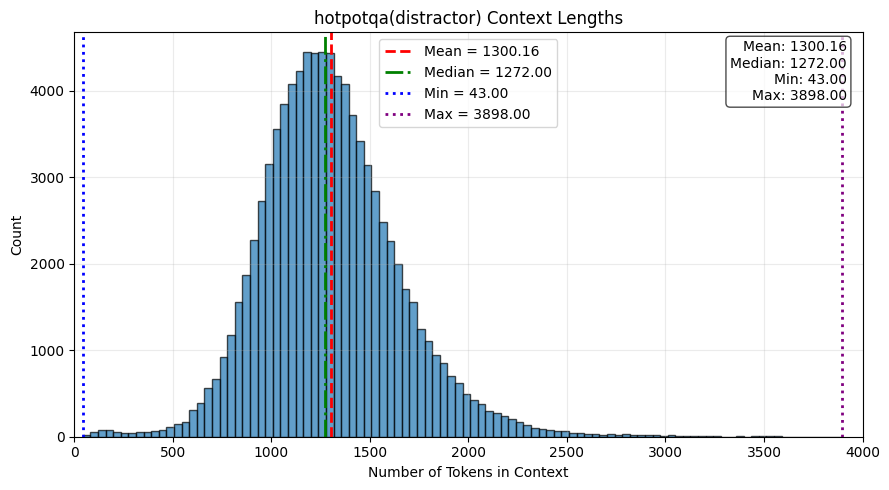

Total samples: 90447


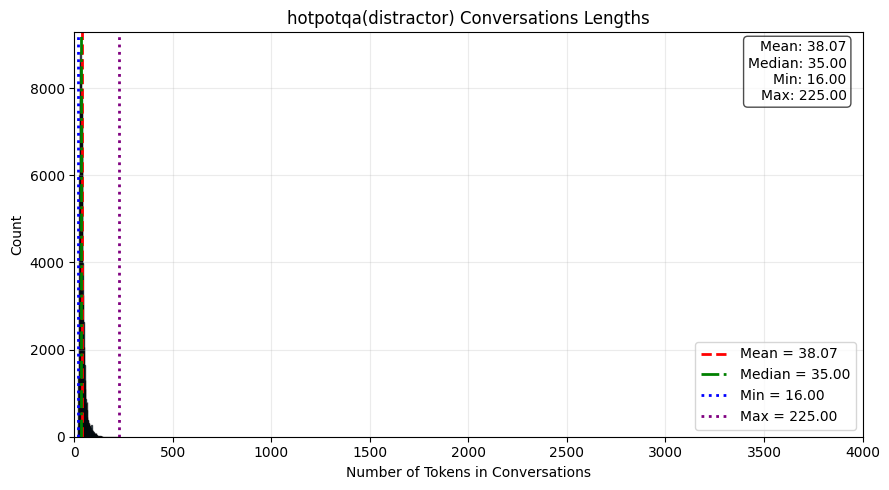

Total samples: 90447


In [30]:
plot_len_hist(
    context_lens_dict['hotpotqa(distractor)'],
    bins=100,
    xlim=(0, 4000),
    title="hotpotqa(distractor) Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['hotpotqa(distractor)'],
    bins=100,
    xlim=(0, 4000),
    title="hotpotqa(distractor) Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# MusiQue

In [31]:
from datasets import load_dataset

data = load_dataset("dgslibisey/MuSiQue")
data = concatenate_datasets([
    data["train"],
])
data = list(data)

item_list = []
for item in data:
    paragraphs = item['paragraphs']
    qd = item['question_decomposition']
    context_list = []
    for p in paragraphs:
        context_list.append(p['paragraph_text'])
    context = "\n\n".join(context_list)
    question = item['question'].strip()
    answer = item['answer'].strip()
    item_list.append({
        'context': context,
        'conversations': [{"role": "user", "content": question}, {"role": "assistant", "content": answer}]
    })

context_lens_dict['musique'], conv_lens_dict['musique'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['musique'] = item_list

Computing token lengths (num_proc=16): 100%|██████████| 19938/19938 [01:04<00:00, 311.20 examples/s]


In [32]:
display_conversations(item_list_dict['musique'])
ift_c1qa_datasets.append('musique')

Pakistan Super League (Urdu: پاکستان سپر لیگ ‬ ‎; PSL) is a Twenty20 cricket league, founded in Lahore on 9 September 2015 with five teams and now comprises six teams. Instead of operating as an association of independently owned teams, the league is a single entity in which each franchise is owned and controlled by investors.

Serena Wilson (August 8, 1933 – June 17, 2007), often known just as "Serena", was a well-known dancer, choreographer, and teacher who helped popularize belly dance in the United States. Serena's work also helped legitimize the dance form and helped it to be perceived as more than burlesque or stripping. Serena danced in clubs in her younger years, opened her own studio, hosted her own television show, founded her own dance troupe, and was the author of several books about belly dance.

Longman, also known as Pearson Longman, is a publishing company founded in London, England, in 1724 and is owned by Pearson PLC.

Bankhaus Lampe is a private bank in Germany, foun

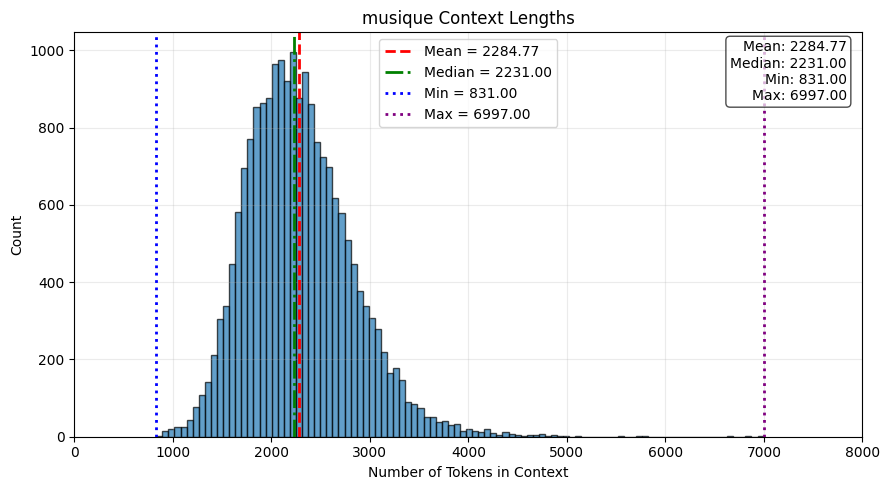

Total samples: 19938


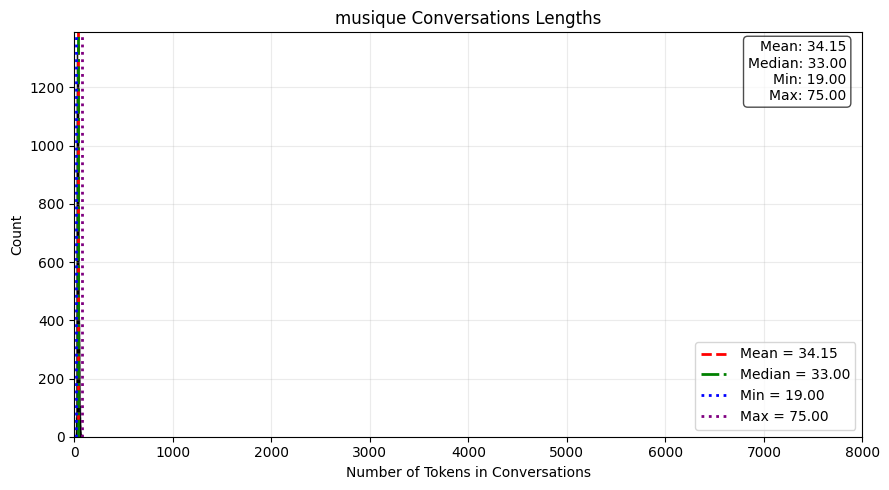

Total samples: 19938


In [33]:
plot_len_hist(
    context_lens_dict['musique'],
    bins=100,
    xlim=(0, 8000),
    title="musique Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['musique'],
    bins=100,
    xlim=(0, 8000),
    title="musique Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# 2WikiMultihupQA

In [12]:
from datasets import load_dataset
from collections import defaultdict
import random
from datasets import concatenate_datasets

data = load_dataset("framolfese/2WikiMultihopQA")

data = concatenate_datasets([
    data["train"],
])
data = list(data)

random.seed(0)

item_list = []
for item in data:
    context_list = []
    for sentences in item['context']['sentences']:
        context_list.append(" ".join(sentences))
    context = "\n\n".join(context_list)
    item_list.append({
        'context': context,
        'conversations': [{"role": "user", "content": item['question'].strip()}, {"role": "assistant", "content": item['answer'].strip()}]
    })

item_list = duplicate_context(item_list, num=2)
context_lens_dict['2wikimultihopqa'], conv_lens_dict['2wikimultihopqa'] = compute_context_and_conversations_tokens_num(item_list)
item_list_dict['2wikimultihopqa'] = item_list

Computing token lengths (num_proc=16): 100%|██████████| 167454/167454 [01:33<00:00, 1794.19 examples/s]


In [35]:
display_conversations(item_list_dict['2wikimultihopqa'])
ift_c1qa_datasets.append('2wikimultihopqa')

Peter Levin is an American director of film, television and theatre.

Brian Patrick Kennedy( born 5 November 1961) is an Irish- born art museum director who has worked in Ireland and Australia, and now lives and works in the United States. He is currently the director of the Peabody Essex Museum. He was the director of the Toledo Museum of Art in Ohio from 2010 to 2019. He was the director of the Hood Museum of Art from 2005 to 2010, and the National Gallery of Australia( Canberra) from 1997- 2004.

Neeli Saali is a 1960 Indian Malayalam film, directed and produced by Kunchacko. The film stars Boban Kunchacko, Bahadoor, Kanchana and S. J. Dev in the lead roles. The film had musical score by K. Raghavan.

Michael Govan( born 1963) is the director of the Los Angeles County Museum of Art since 2006. Prior to this, Govan worked as the director of the Dia Art Foundation in New York City.

Ian Barry is an Australian director of film and TV.

Olav Aaraas( born 10 July 1950) is a Norwegian his

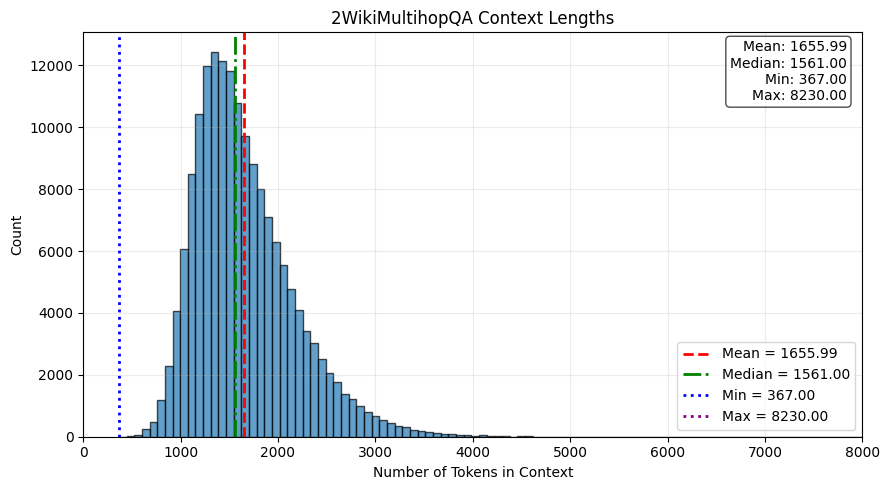

Total samples: 167454


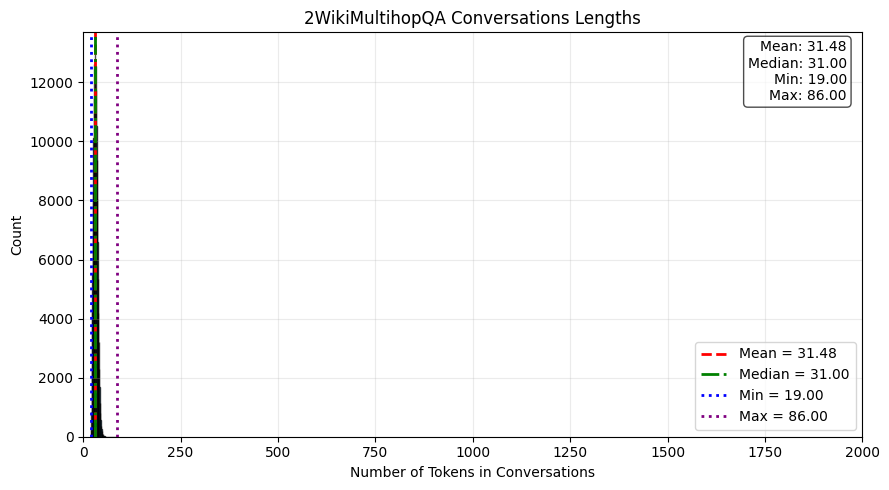

Total samples: 167454


In [36]:
plot_len_hist(
    context_lens_dict['2wikimultihopqa'],
    bins=100,
    xlim=(0, 8000),
    title="2WikiMultihopQA Context Lengths",
    xlabel="Number of Tokens in Context",
)
plot_len_hist(
    conv_lens_dict['2wikimultihopqa'],
    bins=100,
    xlim=(0, 2000),
    title="2WikiMultihopQA Conversations Lengths",
    xlabel="Number of Tokens in Conversations",
)

# Final

In [37]:
print("All datasets:", list(item_list_dict.keys()))
print("IFT C1QA datasets:", ift_c1qa_datasets)

All datasets: ['msmarcov1.1', 'msmarcov2.1', 'squad', 'race', 'duorc/selfrc', 'duorc/paraphraserc', 'hotpotqa(distractor)', 'musique', '2wikimultihopqa']
IFT C1QA datasets: ['msmarcov1.1', 'msmarcov2.1', 'squad', 'race', 'duorc/selfrc', 'duorc/paraphraserc', 'hotpotqa(distractor)', 'musique', '2wikimultihopqa']


In [38]:
# postprocess First letter of answer always uppercase
for dataset_name, item_list in item_list_dict.items():
    for item in item_list:
        for conv in item['conversations']:
            if conv['role'] == 'assistant' and len(conv['content']) > 0:
                conv['content'] = conv['content'][0].upper() + conv['content'][1:]

# randomly show five conversations from each dataset
for dataset_name, item_list in item_list_dict.items():
    print("===============================================")
    print("-----------------------------------------------")
    print("===============================================")
    print(f"Dataset: {dataset_name}")
    display_conversations(item_list, firstk=5)

-----------------------------------------------
Dataset: msmarcov1.1
The key kinds of symmetry relevant in the study of organismal biology are radial and bilateral symmetry. In studying the evolutionary development of symmetry in plants and animals, one fascinating element that emerges is that symmetry is not easily broken in natural selection.

For example, many jellyfish have four oral arms that extend below their body and their body structure can therefore be divided into four equal parts. This type of radial symmetry is referred to as tetramerism. Additionally, two groups of cnidarians, corals and sea anemones, exhibit six-or eight-fold symmetry. These types of symmetry are referred to as hexamerism and octamerism, respectively. It should be noted that cnidarians are not the only animals to exhibit radial symmetry. The echinoderms also display

radial symmetry. n. 1. (Biology) a type of structure of an organism or part of an organism in which a vertical cut through the axis in any 

In [39]:
import pandas as pd
import numpy as np

def table(dataset_names):
    rows = []
    for dataset_name in dataset_names:
        context_lens = context_lens_dict[dataset_name]
        conv_lens = conv_lens_dict[dataset_name]
        rows.append({
            "Dataset": dataset_name,
            "Sample Numbers": len(context_lens),
            "Context Mean": np.mean(context_lens),
            "Context Median": np.median(context_lens),
            "Context Min": np.min(context_lens),
            "Context Max": np.max(context_lens),
            "Conversations Mean": np.mean(conv_lens),
            "Conversations Median": np.median(conv_lens),
            "Conversations Min": np.min(conv_lens),
            "Conversations Max": np.max(conv_lens),
        })
    df = pd.DataFrame(rows)
    df.style.hide(axis="index")
    df.style.format(precision=2).background_gradient(cmap="Blues").hide(axis="index")
    print("====================================================")
    print(df.to_string(index=False))
    print("====================================================")

def statistics(dataset_names):
    print("----------------------------------------------------")
    total_numbers = 0
    total_context_len = 0
    total_conversation_len = 0
    for dataset_name in dataset_names:
        item_list = item_list_dict[dataset_name]
        total_numbers += len(item_list)
        total_context_len += sum(context_lens_dict[dataset_name])
        total_conversation_len += sum(conv_lens_dict[dataset_name])
    avg_contexts_len = total_context_len / total_numbers
    avg_conversations_len = total_conversation_len / total_numbers
    print(dataset_names)
    print(f"Total samples: {total_numbers}")
    print(f"Average context length: {avg_contexts_len:.2f}")
    print(f"Average conversations length: {avg_conversations_len:.2f}")


print(f"All datasets:")
statistics(list(item_list_dict.keys()))
table(list(item_list_dict.keys()))

print(f"ift-cqa-datasets:")
statistics(ift_c1qa_datasets)
table(ift_c1qa_datasets)


All datasets:
----------------------------------------------------
['msmarcov1.1', 'msmarcov2.1', 'squad', 'race', 'duorc/selfrc', 'duorc/paraphraserc', 'hotpotqa(distractor)', 'musique', '2wikimultihopqa']
Total samples: 1250831
Average context length: 1559.93
Average conversations length: 32.82
             Dataset  Sample Numbers  Context Mean  Context Median  Context Min  Context Max  Conversations Mean  Conversations Median  Conversations Min  Conversations Max
         msmarcov1.1           89321   1599.034762          1615.0          413         2893           36.977900                  31.0                 13                243
         msmarcov2.1          558517   1538.547600          1420.0          737         3884           35.486250                  31.0                 13                316
               squad           87599   1604.140127          1588.0          769         2996           27.803753                  27.0                 12                 95
          

In [40]:
# concatenate all into one
import os
import json
import glob
from typing import List
import numpy as np

def generate_dataset(item_list_dict, dataset_names, output_path):
    output_list = []
    context_len_list = []
    conversation_len_list = []
    for dataset_name in dataset_names:
        print(f"Processing dataset: {dataset_name}")
        assert dataset_name in item_list_dict, f"{dataset_name} not in item_list_dict"
        output_list.extend(item_list_dict[dataset_name])
        context_len_list.extend(context_lens_dict[dataset_name])
        conversation_len_list.extend(conv_lens_dict[dataset_name])
    for i in range(len(output_list)):
        output_list[i] = {"contextlen": int(context_len_list[i]), "conversationlen": int(conversation_len_list[i]), "context": output_list[i]["context"], "conversations": output_list[i]["conversations"]}
    with open(output_path, "w") as f:
        json.dump(output_list, f, indent=2)
    print(f"{output_path}: {len(output_list)}")

In [41]:
generate_dataset(item_list_dict, ift_c1qa_datasets, os.path.join("..", "data", "ift_c1qa.json"))

Processing dataset: msmarcov1.1
Processing dataset: msmarcov2.1
Processing dataset: squad
Processing dataset: race
Processing dataset: duorc/selfrc
Processing dataset: duorc/paraphraserc
Processing dataset: hotpotqa(distractor)
Processing dataset: musique
Processing dataset: 2wikimultihopqa
../data/ift_c1qa.json: 1250831
